Author: Akshay Chougule

Creation Date: 13-Feb-2020

Description: This is a v5 of notebook for Human-Protein-Atlas-Competition.

Change log: Try diffrent values of gamma in focal_loss

Possible thing to try next
- Try diffrent model architecture (DenseNet?)
- Move things to Jovian
- Images w/o y
- 512*512 (first train on smaller images)
- 4-channel resnet, your own resnet block
- Less frequent categories: 1. Ignore less frq cats 2. A research paper, SMOTE

In [1]:
import pandas as pd
import wget
import time
import os
import copy

In [2]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

In [3]:
import fastai
from fastai.vision.image import *
from fastai.vision import *
from fastai.metrics import *
from fastai.vision import *

In [4]:
data_root = '/home/ubuntu/datasets/human-protein-atlas/'

In [5]:
train_labels = pd.read_csv(os.path.join(data_root,'train.csv'))
train_labels.head(5)

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


__Create the databunch__

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
additional_aug=[*zoom_crop(scale=(0.75,1.25), do_rand=False), 
#                     brightness(scale=(0.4, 0.6)), 
#                     contrast(scale=(0.6, 1.4), p=0.75)
                   ]
#tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
tfms = get_transforms(dihedral_affine(),max_lighting=0.2, max_zoom=1.15, xtra_tfms=additional_aug)

In [8]:
test = ImageList.from_csv(data_root,'sample_submission.csv',folder='test_512by512',suffix='.png')

In [9]:
src = (ImageList.from_csv(data_root,'train.csv',folder='train_512by512',suffix='.png')
        .split_by_rand_pct(0.2)
        .label_from_df(cols='Target',label_delim=' ')
       .add_test(test))

In [10]:
data = (src.transform(tfms, size=512)
        .databunch(bs = 8).normalize(imagenet_stats))

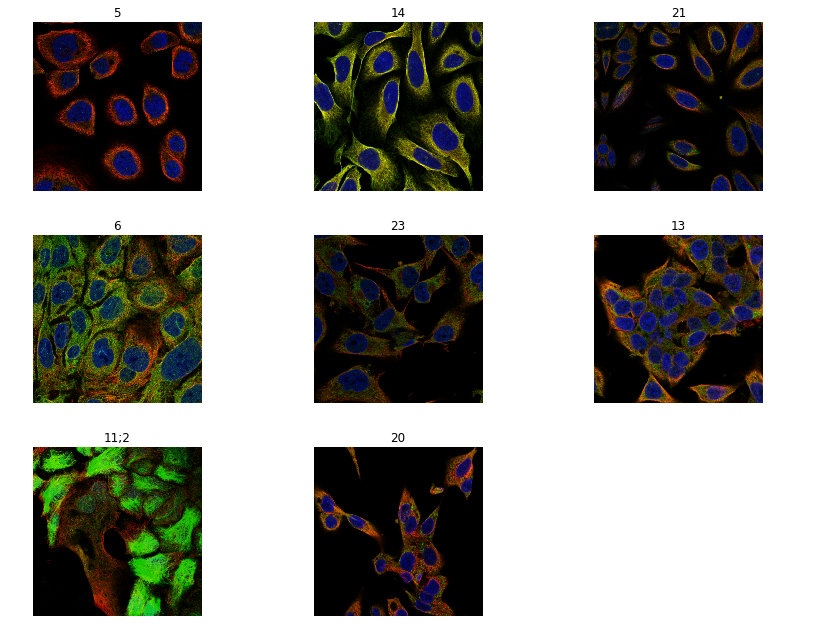

In [11]:
data.show_batch(rows=3, figsize=(12,9))

In [220]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

In [26]:
# Focal loss : https://colab.research.google.com/drive/1NiUwI6ohF1b9TthutyfJQnOJ2i39R5cJ#scrollTo=qo8kiV3mtC-S

def focal_loss(y_pred,y_true,alpha=0.25,gamma=0):
    
    if isinstance(alpha,(list,tuple)):
        fore_alpha = alpha[0] # postive sample ratio in the entire dataset
        back_alpha = alpha[1] #(1-alpha) # negative ratio in the entire dataset
    elif isinstance(alpha ,(int,float)):
        fore_alpha = alpha
        back_alpha = (1-alpha)
        
    n_positives = (y_true!=0).sum() # all postive anchors for 28 class
     #y_true = torch.eye(y_pred.shape[-1])[y_true].cuda() # one hot vector for all prediction
    y_pred = F.softmax(y_pred,dim=1) # apply softmax
    
    y_true = y_true.to('cuda')
        
    # in the dataset background classes is taken in the front so 1 background class + 27 classes = 28 classes
    back_pred = y_pred[:,0:1] # 1st column background
    fore_pred = y_pred[:,1:]  # 20 columns foreground
    back_true = y_true[:,0:1]  # 1st column background
    fore_true = y_true[:,1:] # 20 columns foreground
    
    alpha_factor = torch.cat([ back_true *back_alpha ,  fore_true * fore_alpha],dim=1)  ## alpha factor      
    focal_weight = torch.cat([ back_true * back_pred , fore_true * (1-fore_pred) ] ,dim=1) #because background is also a class so (1-back_true) will lead to false output
        
    cross_entropy = -1 *  torch.log(y_pred) # normal cross entropy
    focal_weight = focal_weight.to('cuda')
    cross_entropy = cross_entropy.to('cuda')
    alpha_factor = alpha_factor.to('cuda')
    
    loss =  alpha_factor * (focal_weight ** gamma) * cross_entropy # focal loss with modulating factor
    
    # normalize the loss with positive anchors
    return loss.sum()/n_positives  # if want to use it for anything else other then SSD use loss = loss.sum()/len(y_pred)

In [27]:
arch = models.resnet18
F1 = MultiLabelFbeta(beta=2, average="macro")

In [28]:
setattr(src, 'device', 'cuda') 

In [29]:
learn = cnn_learner(data, arch, metrics=F1)

__PART 1: Let's establish baseline with gamma = 0__

In [30]:
learn.loss_func=focal_loss

In [31]:
learn.lr_find()

epoch,train_loss,valid_loss,multi_label_fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


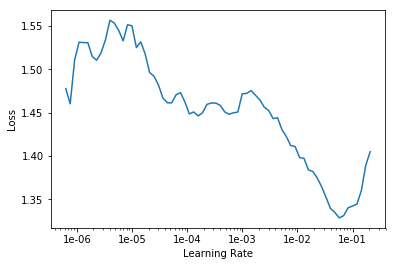

In [32]:
learn.recorder.plot()

In [33]:
lr = 0.001

In [34]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,multi_label_fbeta,time
0,0.727996,0.683244,0.229337,02:58
1,0.673478,0.643224,0.274675,03:01
2,0.658434,0.616653,0.309232,03:00
3,0.640163,0.608615,0.322376,02:58
4,0.618690,0.600328,0.318781,02:58


In [35]:
learn.unfreeze()

epoch,train_loss,valid_loss,multi_label_fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


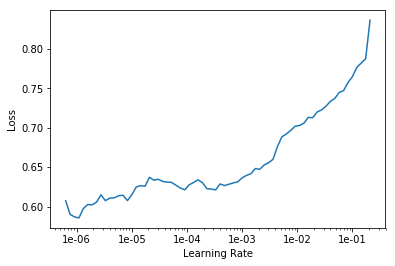

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(15, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,multi_label_fbeta,time
0,0.617417,0.591561,0.326415,04:00
1,0.598871,0.573756,0.346218,04:01
2,0.575802,0.562892,0.360130,04:02
3,0.564818,0.550387,0.382513,04:00
4,0.556065,0.526123,0.430614,04:00
5,0.553219,0.517914,0.442144,04:01
6,0.544462,0.524534,0.438760,04:01
7,0.519567,0.507769,0.465292,04:01
8,0.517843,0.492788,0.472422,04:02
9,0.502170,0.487753,0.483362,04:02


__PART 2: gamma = 1__

In [38]:
def focal_loss(y_pred,y_true,alpha=0.25,gamma=1):
    
    if isinstance(alpha,(list,tuple)):
        fore_alpha = alpha[0] # postive sample ratio in the entire dataset
        back_alpha = alpha[1] #(1-alpha) # negative ratio in the entire dataset
    elif isinstance(alpha ,(int,float)):
        fore_alpha = alpha
        back_alpha = (1-alpha)
        
    n_positives = (y_true!=0).sum() # all postive anchors for 28 class
     #y_true = torch.eye(y_pred.shape[-1])[y_true].cuda() # one hot vector for all prediction
    y_pred = F.softmax(y_pred,dim=1) # apply softmax
    
    y_true = y_true.to('cuda')
        
    # in the dataset background classes is taken in the front so 1 background class + 27 classes = 28 classes
    back_pred = y_pred[:,0:1] # 1st column background
    fore_pred = y_pred[:,1:]  # 20 columns foreground
    back_true = y_true[:,0:1]  # 1st column background
    fore_true = y_true[:,1:] # 20 columns foreground
    
    alpha_factor = torch.cat([ back_true *back_alpha ,  fore_true * fore_alpha],dim=1)  ## alpha factor      
    focal_weight = torch.cat([ back_true * back_pred , fore_true * (1-fore_pred) ] ,dim=1) #because background is also a class so (1-back_true) will lead to false output
        
    cross_entropy = -1 *  torch.log(y_pred) # normal cross entropy
    focal_weight = focal_weight.to('cuda')
    cross_entropy = cross_entropy.to('cuda')
    alpha_factor = alpha_factor.to('cuda')
    
    loss =  alpha_factor * (focal_weight ** gamma) * cross_entropy # focal loss with modulating factor
    
    # normalize the loss with positive anchors
    return loss.sum()/n_positives  # if want to use it for anything else other then SSD use loss = loss.sum()/len(y_pred)

In [42]:
learn = cnn_learner(data, arch, metrics=F1)
learn.loss_func=focal_loss

epoch,train_loss,valid_loss,multi_label_fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


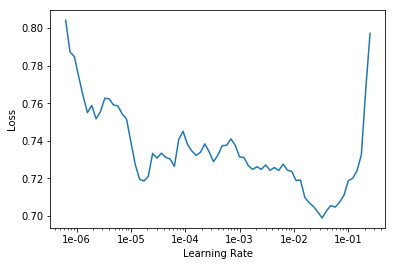

In [43]:
learn.lr_find()
learn.recorder.plot()

In [44]:
# 0.01 gives NaN
lr = 0.001
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,multi_label_fbeta,time
0,0.438389,0.396370,0.185115,02:59
1,0.419862,0.371737,0.216827,03:00
2,0.369702,0.349074,0.253755,03:00
3,0.380484,0.338476,0.262937,03:03
4,0.365027,0.334859,0.268019,03:00


In [45]:
learn.unfreeze()

epoch,train_loss,valid_loss,multi_label_fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


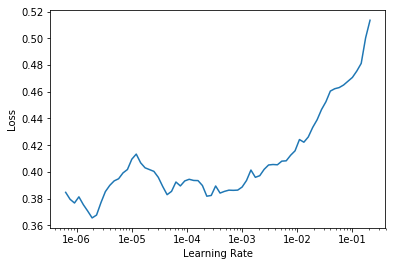

In [46]:
learn.lr_find()
learn.recorder.plot()

In [47]:
learn.fit_one_cycle(15, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,multi_label_fbeta,time
0,0.357443,0.327059,0.273504,03:59
1,0.342316,0.314357,0.280246,03:59
2,0.333747,0.298832,0.311613,03:57
3,0.316984,0.289146,0.325498,03:58
4,0.311237,0.270171,0.354100,03:57
5,0.270368,0.264218,0.362760,03:59
6,0.265125,0.253631,0.380745,04:00
7,0.259870,0.247563,0.388257,03:57
8,0.242847,0.242566,0.392300,03:57
9,0.241032,0.239147,0.396215,03:57


### Testing the data

__Making the predictions__

In [422]:
preds, _ = learn.get_preds(DatasetType.Test)

fnames = pd.Series(learn.data.test_ds.items).str.replace('.png|/home/ubuntu/datasets/human-protein-atlas/test_512by512/','')
sample_submission = pd.read_csv(data_root+'sample_submission.csv')

In [423]:
learn.data.test_ds.items

array(['/home/ubuntu/datasets/human-protein-atlas/test_512by512/00008af0-bad0-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/0000a892-bacf-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/0008baca-bad7-11e8-b2b9-ac1f6b6435d0.png', ...,
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/ffdfc590-bad4-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/ffecb8a4-bad4-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/fff03816-bad5-11e8-b2b9-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/fffe6f9c-bacd-11e8-b2b8-ac1f6b6435d0.png'],
      dtype='<U96')

Let's try playing around with the threshold

In [424]:
thresholds = [0.18,0.16,0.14,0.12,0.10]

for thresh in thresholds:
    labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]
    fnames = pd.Series(learn.data.test_ds.items).str.replace('.png|/home/ubuntu/datasets/human-protein-atlas/test_512by512/','')
    df = pd.DataFrame({'Id':fnames, 'Predicted':labelled_preds}, columns=['Id', 'Predicted'])
    df2 = pd.merge(sample_submission['Id'], df, on='Id', how='left')
    df2.to_csv('protein_classification_nb-V4_stag3_thresh_'+str(thresh)+'.csv', header=True, index=False)

In [425]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V4_stag3_thresh_0.18.csv -m "Model v4 with resnet18 stage-3 and thrsd 0.18"

100%|█████████████████████████████████████████| 448k/448k [00:00<00:00, 794kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [426]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V4_stag3_thresh_0.16.csv -m "Model v4 with resnet18 stage-3 and thrsd 0.16"

100%|█████████████████████████████████████████| 448k/448k [00:00<00:00, 651kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [427]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V4_stag3_thresh_0.14.csv -m "Model v4 with resnet18 stage-3 and thrsd  0.14"

100%|█████████████████████████████████████████| 448k/448k [00:00<00:00, 686kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [428]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V4_stag3_thresh_0.12.csv -m "Model v4 with resnet18 stage-3 and thrsd 0.12"

100%|█████████████████████████████████████████| 449k/449k [00:00<00:00, 634kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [429]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V4_stag3_thresh_0.1.csv -m "Model v4 with resnet18 stage-3 and thrsd  0.1"

100%|█████████████████████████████████████████| 449k/449k [00:00<00:00, 706kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [430]:
!kaggle competitions submissions -c human-protein-atlas-image-classification > results.txt
!head results.txt

fileName                                               date                 description                                       status    publicScore  privateScore  
-----------------------------------------------------  -------------------  ------------------------------------------------  --------  -----------  ------------  
protein_classification_nb-V4_stag3_thresh_0.1.csv      2020-02-12 06:59:42  Model v4 with resnet18 stage-3 and thrsd  0.1     complete  0.09255      0.09876       
protein_classification_nb-V4_stag3_thresh_0.12.csv     2020-02-12 06:59:23  Model v4 with resnet18 stage-3 and thrsd 0.12     complete  0.09100      0.09799       
protein_classification_nb-V4_stag3_thresh_0.14.csv     2020-02-12 06:58:56  Model v4 with resnet18 stage-3 and thrsd  0.14    complete  0.09024      0.09700       
protein_classification_nb-V4_stag3_thresh_0.16.csv     2020-02-12 06:58:32  Model v4 with resnet18 stage-3 and thrsd 0.16     complete  0.08980      0.09600       
protein_classifi